In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorboard as tb
from tensorflow import keras
from keras import datasets, layers, models, Input, Model, activations
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
import scipy


2024-02-14 17:18:11.909634: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-14 17:18:11.914799: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-14 17:18:11.960616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 17:18:11.960647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 17:18:11.962044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
LABEL_KEY = 'open'

activity_df = pd.read_csv("Data/activity.csv", index_col=0)
activity_df['open'] = np.repeat('Open',len(activity_df))
atac_df = pd.read_csv("Data/ATAC/labeled_data_164.csv", index_col=0)
len(activity_df), len(atac_df)


(118364, 53632)

In [22]:
#Experiment 3
n_folds = 7
take_activity = activity_df[activity_df['data_batch_name']=='Genomic'][atac_df.columns.to_list()].copy()
take_atac = atac_df[atac_df['open'] == 'Closed'].copy()
df_3 = pd.concat([take_activity,take_atac])
df_3['set'] = random.choices(['TRAIN','TEST'], cum_weights=[1-0.15,1], k=len(df_3))
df_3['fold'] = random.choices(range(1,n_folds+1), k=len(df_3))

#df_1['set'].value_counts(), df_1['fold'].value_counts(), df_1['open'].value_counts()

df_3.to_csv("Data/Experimental/df_3.csv", index_label='label')

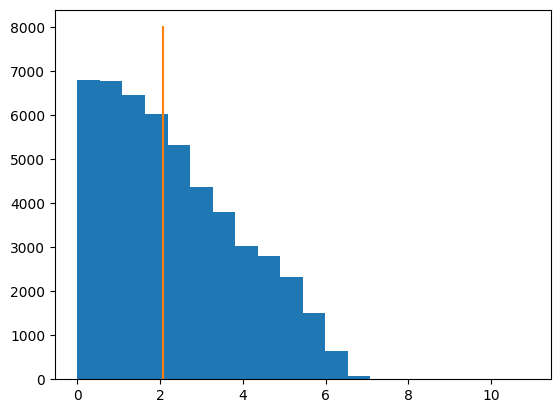

(set
 TRAIN    42505
 TEST      7495
 Name: count, dtype: int64,
 fold
 4    7329
 6    7317
 1    7153
 3    7122
 5    7060
 7    7029
 2    6990
 Name: count, dtype: int64,
 open
 Closed    25000
 Open      25000
 Name: count, dtype: int64)

In [20]:
# # Experiment 2
# num_samples = 50000
# n_folds = 7
# df_2 = activity_df.iloc[:num_samples].copy()
# df_2['set'] = random.choices(['TRAIN','TEST'], cum_weights=[1-0.15,1], k=len(df_2))
# df_2['fold'] = random.choices(range(1,n_folds+1), k=len(df_2))
# df_2['expression_log2'] = df_2['expression_log2'].map(abs)

# df2_median = df_2['expression_log2'].median()

# df_2['open'] = df_2['expression_log2'].map(lambda x: 'Open' if x>df2_median else 'Closed')
# df_2.to_csv("Data/Experimental/df_2.csv", index_label='label')


# plt.hist(df_2['expression_log2'], bins=20)
# plt.plot([df2_median,df2_median],[0,8000])
# plt.show()

# df_2['set'].value_counts(), df_2['fold'].value_counts(), df_2['open'].value_counts()

In [8]:
# Experiment 1
# n_folds = 7
# num_samples = 25000
# take_activity = activity_df.iloc[:num_samples][atac_df.columns.to_list()].copy()
# take_atac = atac_df[atac_df['open'] == 'Closed'].copy()
# df_1 = pd.concat([take_activity,take_atac])
# df_1['set'] = random.choices(['TRAIN','TEST'], cum_weights=[1-0.15,1], k=len(df_1))
# df_1['fold'] = random.choices(range(1,n_folds+1), k=len(df_1))

# #df_1['set'].value_counts(), df_1['fold'].value_counts(), df_1['open'].value_counts()

# df_1.to_csv("Data/Experimental/df_1.csv", index_label='label')

In [115]:
def one_hot_seqs(seqs) -> np.array:
    static_1hotmap = {
        'A' : np.array([1,0,0,0]),
        'a' : np.array([1,0,0,0]),
        'C' : np.array([0,1,0,0]),
        'c' : np.array([0,1,0,0]),
        'G' : np.array([0,0,1,0]),
        'g' : np.array([0,0,1,0]),
        'T' : np.array([0,0,0,1]),
        't' : np.array([0,0,0,1]),
    }
    onehot_seqs = []
    for seq in seqs:
        onehot_seqs.append(
            [static_1hotmap[seq[i]] if seq[i] in static_1hotmap.keys() else static_1hotmap[random.choice(['A','C','G','T'])] for i in range(len(seq))]
        )
    return np.stack(onehot_seqs)



In [123]:
LABEL_KEY = 'open'
activity_df = pd.read_csv("Data/activity.csv", index_col=0)
print(activity_df['data_batch_name'].value_counts())
activity_df = activity_df[activity_df['data_batch_name'].isin(["Genomic"])]


# Enhancer:Open - Inactive:Closed
activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Open' if x in ['WeakEnhancer'] else 'Closed')
test_df = activity_df[activity_df['activity_bin'].isin(["WeakEnhancer","Inactive"])]
groups = [['Inactive'],['WeakEnhancer']]

# Silencer:Open - Inactive:Closed 
# activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Open' if x == 'Silencer' else 'Closed')
# test_df = activity_df[activity_df['activity_bin'].isin(['Silencer','Inactive'])]
# groups = [['Inactive'],['Silencer']]

# Enhancer+Silencer:Open - Inactive:Closed
# activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Closed' if x=='Inactive' else 'Open')
# test_df = activity_df
# groups = [['Inactive'],['Enhancer','Silencer']]

# Enhancer:Open - Silencers:Closed
# activity_df[LABEL_KEY] = activity_df['activity_bin'].map(lambda x: 'Closed' if x=='Silencer' else 'Open')
# test_df = activity_df[activity_df['activity_bin'] != 'Inactive']
# groups = [['Silencer'],['Enhancer']]

# test_df = activity_df[(activity_df['activity_bin'] != 'Silencer') & (activity_df['expression_log2'] >0)]


x_test = one_hot_seqs(test_df['sequence'])
encoder = LabelEncoder()
encoder.fit(test_df[LABEL_KEY])
classes = encoder.classes_
num_classes = len(classes)
y_test = encoder.transform(test_df[LABEL_KEY])
y_test = keras.utils.to_categorical(y_test, num_classes)


data_batch_name
Round4a              59645
NOT_TRAINING_DATA    14650
Round4b              11169
Round3b               7526
Round3c               6183
Genomic               4658
Round3a               4438
CrxMotifMutant        4221
Round2                3820
HighConfidence        2054
Name: count, dtype: int64


In [124]:
classes, encoder.transform(classes), test_df[LABEL_KEY].value_counts()


(array(['Closed', 'Open'], dtype=object),
 array([0, 1]),
 open
 Closed    1454
 Open      1437
 Name: count, dtype: int64)

In [125]:
best_model = keras.models.load_model(os.path.join('ATAC7_164_10663735','5','cnn_model.keras'))

In [126]:

results = best_model.evaluate(x_test,y_test,batch_size=128, verbose=1)

predictions_ = best_model.predict(x_test, verbose=1)

91/91 [==============================] - 2s 15ms/step


In [127]:
entropies = [scipy.stats.entropy(p) for p in predictions_]
expression = test_df['expression_log2'].values

In [128]:
truths = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions_, axis=1)

In [129]:
print(classification_report(truths,predictions,target_names=classes))
report = classification_report(truths,predictions,target_names=classes, output_dict=True)


              precision    recall  f1-score   support

      Closed       0.53      0.24      0.33      1454
        Open       0.50      0.78      0.61      1437

    accuracy                           0.51      2891
   macro avg       0.51      0.51      0.47      2891
weighted avg       0.52      0.51      0.47      2891



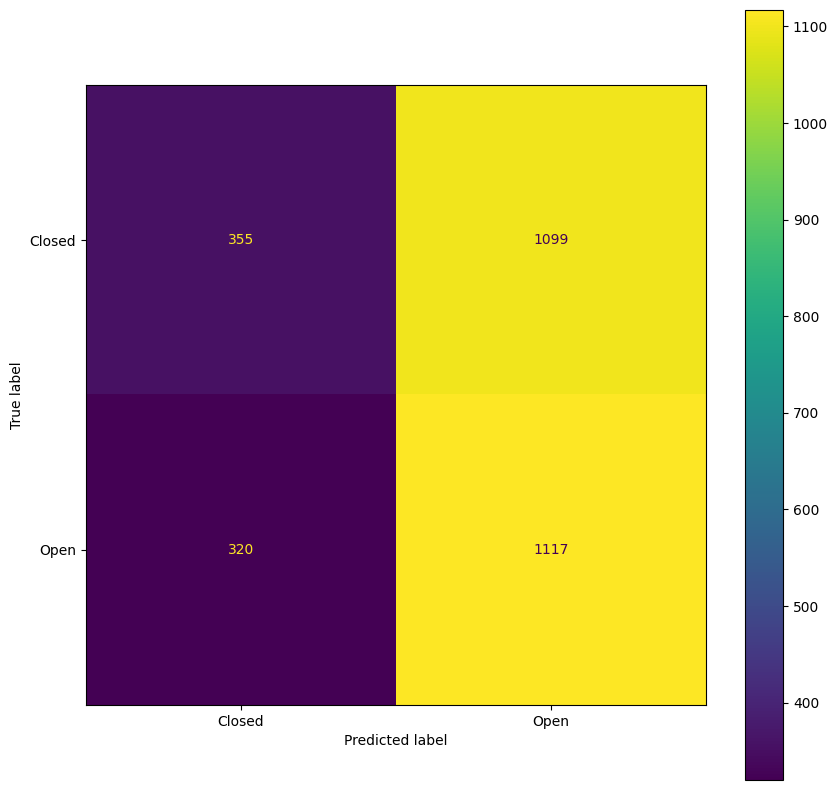

In [130]:
ConfusionMatrixDisplay.from_predictions(truths,predictions,display_labels=classes)

In [ ]:
open_close = [[0,0],[0,0]]

for i in range(len(truths)):
    open_close[truths[i]][predictions[i]] += 1


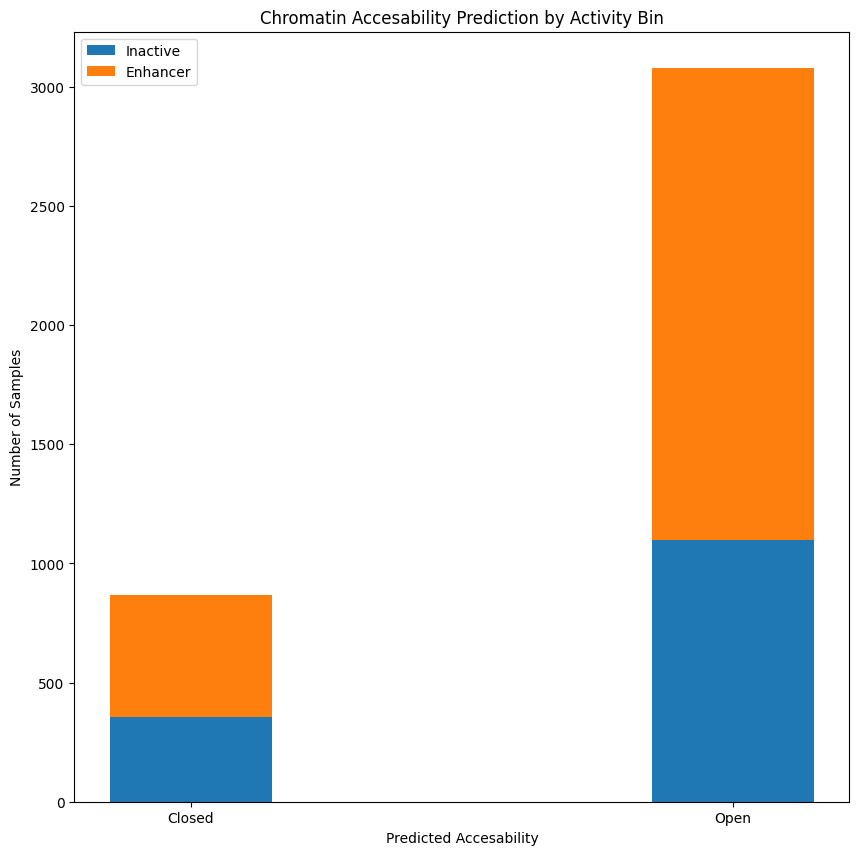

In [ ]:

bottom = np.zeros(2)
x = classes

fig, ax = plt.subplots()

for i in range(2):
    ax.bar(x, open_close[i], width=0.3, label="+".join(groups[i]), bottom=bottom)
    bottom += open_close[i]
plt.legend()
plt.ylabel("Number of Samples")
plt.xlabel("Predicted Accesability")
plt.title("Chromatin Accesability Prediction by Activity Bin")

plt.show()


In [ ]:
#print(classification_report(truths,predictions,target_names=classes))
# report1 = classification_report(truths,predictions,target_names=classes, output_dict=True)
# report1 = report1['weighted avg']

In [ ]:
a = classification_report(truths,predictions,target_names=classes)

In [ ]:
with open("file.txt", 'a') as file:
    file.write('\n hello world')